In [3]:
from custom_utils import load_and_concatenate_parquet_files
df = load_and_concatenate_parquet_files('data/preprocessed_big_training_df')
display(df)

,preprocessed_text,label
0,donald trump respond mockery fake swedish atta...,1
1,tweetwavethis time true pantstweetwave anthony...,1
2,rubio prospect trump president worrisome reute...,0
3,trump lifts cyber command status boost cyber d...,0
4,big republican lie economy tear apart minute v...,1
...,...,...
63116,half briton want stay eu polledinburgh reuters...,0
63117,bill hillary clinton inc sale right pricein sp...,1
63118,orlando gunman shoot time autopsy find new yor...,0
63119,lethal gap supreme court handle death penalty ...,0


In [2]:
from joblib import Parallel, delayed
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
from spacy.cli import download
import gc

# Download the SpaCy model if not already installed
model_name = "en_core_web_sm"

try:
    nlp = spacy.load(model_name)
    print(f"Successfully loaded model: {model_name}")
except OSError:
    print(f"Model '{model_name}' not found. Downloading...")
    download(model_name)
    nlp = spacy.load(model_name)
    print(f"Successfully downloaded and loaded model: {model_name}")

nlp.add_pipe('sentencizer')

stopwords = STOP_WORDS  

# Function to lemmatize a single document
def lemmatize_doc(doc):
    return ' '.join(
        tok.lemma_.lower()
        for tok in doc
        if tok.is_alpha and tok.text.lower() not in stopwords
    )

def chunker(iterable, total_length, chunksize):
    for pos in range(0, total_length, chunksize):
        yield iterable[pos: pos + chunksize]
        
# Flatten a list of lists
def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

# Process a chunk of texts in parallel
def process_chunk_return_docs(texts):
    return list(nlp.pipe(texts, batch_size=20))

# Main preprocessing function for parallel processing
def preprocess_parallel_return_docs(texts, chunksize=100):
    with Parallel(n_jobs=4, backend='multiprocessing', prefer="processes") as executor:
        tasks = (delayed(process_chunk_return_docs)(chunk) for chunk in chunker(texts, len(texts), chunksize=chunksize))
        result = executor(tasks)
    gc.collect()
    return flatten(result)

Successfully loaded model: en_core_web_sm


In [3]:
docs = preprocess_parallel_return_docs(df["cleaned_text"], chunksize=1000)

In [4]:
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import seaborn as sns

def plot_dependency_relations(texts):
    dependencies = []
    for doc in nlp.pipe(texts, batch_size=20):
        dependencies.extend([token.dep_ for token in doc if token.is_alpha])

    dep_counts = Counter(dependencies)
    plt.figure(figsize=(10, 6))
    plt.bar(dep_counts.keys(), dep_counts.values(), color='skyblue')
    plt.title("Dependency Relations Frequency")
    plt.xlabel("Dependency Relation")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

def plot_named_entities(texts):
    entity_labels = []
    for doc in nlp.pipe(texts, batch_size=20):
        entity_labels.extend([ent.label_ for ent in doc.ents])

    entity_counts = Counter(entity_labels)
    plt.figure(figsize=(10, 6))
    plt.bar(entity_counts.keys(), entity_counts.values(), color='orange')
    plt.title("Named Entity Recognition (NER) Frequency")
    plt.xlabel("Entity Type")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()
    
    

def plot_entity_cooccurrences(texts):
    cooccurrences = []
    for doc in nlp.pipe(texts, batch_size=20):
        for sent in doc.sents:
            entities = [ent.text for ent in sent.ents]
            cooccurrences.extend(combinations(entities, 2))

    cooccurrence_counts = Counter(cooccurrences)
    most_common = cooccurrence_counts.most_common(10)  # Top 10 pairs

    pairs, counts = zip(*most_common)
    pair_labels = [' & '.join(pair) for pair in pairs]

    plt.figure(figsize=(10, 6))
    plt.barh(pair_labels, counts, color='green')
    plt.title("Top Entity Co-Occurrences")
    plt.xlabel("Frequency")
    plt.ylabel("Entity Pairs")
    plt.gca().invert_yaxis()
    plt.show()
    
def plot_sentence_length_distribution(texts):
    sentence_lengths = []
    for doc in nlp.pipe(texts, batch_size=20):
        sentence_lengths.extend([len(sent) for sent in doc.sents])

    plt.figure(figsize=(10, 6))
    sns.histplot(sentence_lengths, bins=20, kde=True, color='purple')
    plt.title("Sentence Length Distribution")
    plt.xlabel("Sentence Length (Number of Tokens)")
    plt.ylabel("Frequency")
    plt.show()

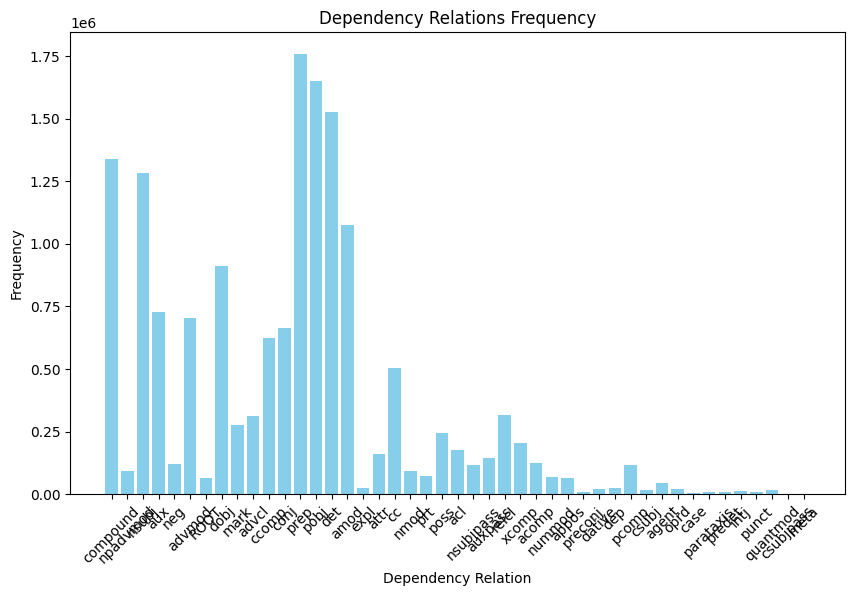

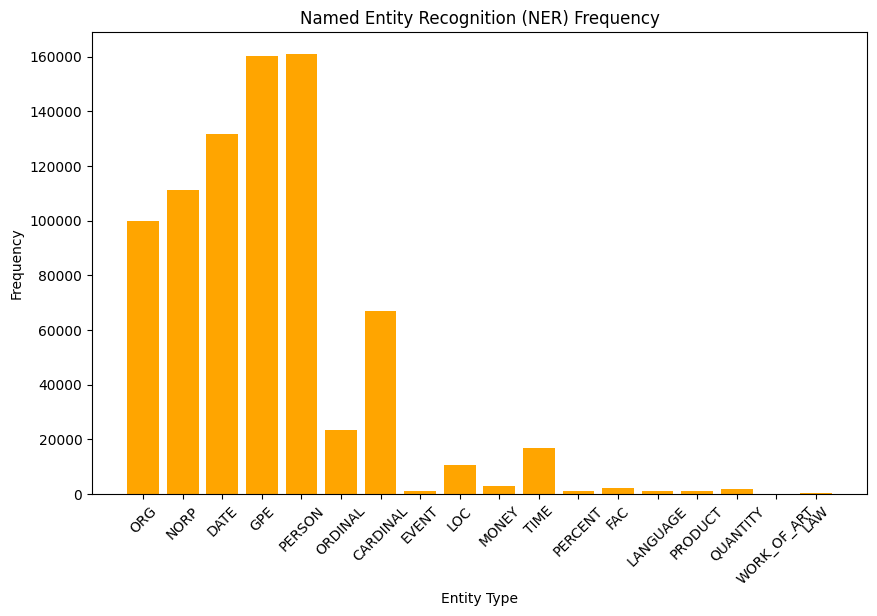

: 

In [5]:
# Perform analyses
plot_dependency_relations([doc.text for doc in docs])
plot_named_entities([doc.text for doc in docs])
plot_entity_cooccurrences(docs)  # Co-occurrences use Docs directly
plot_sentence_length_distribution(docs)  # Sentence lengths use Docs directly

In [3]:
import pandas as pd
df = pd.read_parquet("data/train_cleaned.parquet")  # Replace with your actual dataset path
display(df)

,title,author,text,label,complete_text,cleaned_text,lemmatized_text,preprocessed_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...,house dem aide we did not even see comeys lett...,house dem aide comey letter jason chaffetz twe...,house dem aide comey letter jason chaffetz twe...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",flynn hillary clinton big woman on campus brei...,flynn hillary clinton big woman campus breitba...,flynn hillary clinton big woman campus breitba...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...,why the truth might get you fired why the trut...,truth fire truth fire october tension intellig...,truth fire truth fire october tension intellig...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...,civilians killed in single us airstrike have b...,civilian kill single airstrike identify video ...,civilian kill single airstrike identify video ...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...,iranian woman jailed for fictional unpublished...,iranian woman jail fictional unpublished story...,iranian woman jail fictional unpublished story...
...,...,...,...,...,...,...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,Rapper T.I.: Trump a ’Poster Child For White S...,rapper t i trump a poster child for white supr...,rapper t trump poster child white supremacy ra...,rapper t trump poster child white supremacy ra...
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",n f l playoffs schedule matchups and odds the ...,n f l playoff schedule matchup odd new york ti...,n f l playoff schedule matchup odd new york ti...
20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,Macy’s Is Said to Receive Takeover Approach by...,macys is said to receive takeover approach by ...,macys say receive takeover approach hudsons ba...,macys receive takeover approach hudsons bay ne...
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,"NATO, Russia To Hold Parallel Exercises In Bal...",nato russia to hold parallel exercises in balk...,nato russia hold parallel exercise balkans nat...,nato russia hold parallel exercise balkans nat...


In [3]:
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


# Function to generate and save wordclouds
def save_wordcloud_images_from_column(
    df, column, label_column=None, output_dir="wordclouds", topic_column=None
):
    """
    Generates and saves wordclouds based on the provided column in the dataset.
    
    Args:
        df (pd.DataFrame): Input dataset.
        column (str): The column containing the article text.
        label_column (str): Column indicating labels (e.g., fake/real news).
        output_dir (str): Directory to save the wordclouds.
        topic_column (str): Column indicating topics for optional topic-based filtering.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Overall dataset
    # overall_text = ' '.join(df[column])
    # overall_wordcloud = WordCloud(width=1600, height=800, background_color='white', margin=0).generate(overall_text)
    # # generate plot and save as file in current directory
    # plt.figure(figsize=(8, 8))
    # plt.imshow(overall_wordcloud, interpolation="bilinear")
    # plt.axis("off")  # Turn off the axes
    # plt.gca().patch.set_visible(False)  # Hide the patch
    # plt.savefig(f'{output_dir}/overall' + ".svg", dpi=700, format="svg", transparent=True, bbox_inches='tight', pad_inches=0)
    # plt.close()
    # # save_wordcloud_as_svg(overall_wordcloud, f"{output_dir}/overall.svg")

    # Fake news and real news subsets (if label_column is provided)
    if label_column:
        for label in df[label_column].unique():
            label_text = ' '.join(df[df[label_column] == label][column])
            label_wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(label_text)
            label_name = "fake_news" if label == 1 else "real_news"
            plt.imshow(label_wordcloud, interpolation="bilinear")
            plt.axis("off")  # Turn off the axes
            plt.gca().patch.set_visible(False)  # Hide the patch
            plt.savefig(f'{output_dir}/{label_name}' + ".svg", dpi=700, format="svg", transparent=True, bbox_inches='tight', pad_inches=0)
            plt.close()

# Load your dataset
df = pd.read_parquet("data/train_cleaned.parquet")  # Replace with your actual dataset path

# Call the function to save wordclouds
save_wordcloud_images_from_column(df, column="preprocessed_text", label_column="label")


In [10]:
df = pd.read_parquet("../data/train_cleaned.parquet")  # Replace with your actual dataset path

def calculate_vocab_richness(text):
    words = text.split()  # Tokenize the text into words
    unique_words = set(words)
    return len(unique_words) / len(words) if len(words) > 0 else 0

# Add a new column for precomputed text lengths
df['text_length'] = df['preprocessed_text'].apply(len)

df['vocab_richness'] = df['preprocessed_text'].apply(calculate_vocab_richness)
print(df.columns)
df = df.drop(columns=['title', 'author', 'text', 'complete_text', 'cleaned_text',
       'lemmatized_text'])
display(df)
# Save the updated DataFrame (e.g., as a CSV or Parquet file)
df.to_parquet("../data/analysis_df.parquet", index=False)  # Preferred for performance

Index(['title', 'author', 'text', 'label', 'complete_text', 'cleaned_text',
       'lemmatized_text', 'preprocessed_text', 'text_length',
       'vocab_richness'],
      dtype='object')


,label,preprocessed_text,text_length,vocab_richness
0,1,house dem aide comey letter jason chaffetz twe...,2903,0.596491
1,0,flynn hillary clinton big woman campus breitba...,2425,0.732733
2,1,truth fire truth fire october tension intellig...,4561,0.644013
3,1,civilian kill single airstrike identify video ...,1892,0.579545
4,1,iranian woman jail fictional unpublished story...,656,0.666667
...,...,...,...,...
20795,0,rapper t trump poster child white supremacy ra...,1133,0.750000
20796,0,n f l playoff schedule matchup odd new york ti...,3371,0.478899
20797,0,macys receive takeover approach hudsons bay ne...,2972,0.636364
20798,1,nato russia hold parallel exercise balkans nat...,1236,0.614907


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
df = pd.read_parquet("data/train_cleaned.parquet")  # Replace with your actual dataset path

# Get top n-grams for real and fake news separately
real_texts = df[df['label'] == 0]['preprocessed_text']
fake_texts = df[df['label'] == 1]['preprocessed_text']

# Function to extract n-grams for different ranges
def get_all_ngrams(texts, n_range=(1, 4), top_n=20):
    all_ngrams = []
    for n in range(n_range[0], n_range[1] + 1):
        vectorizer = CountVectorizer(ngram_range=(n, n))
        ngrams = vectorizer.fit_transform(texts)
        sum_ngrams = ngrams.sum(axis=0)
        freq = [(word, sum_ngrams[0, idx], n) for word, idx in vectorizer.vocabulary_.items()]
        all_ngrams.extend(sorted(freq, key=lambda x: x[1], reverse=True)[:top_n])
    return all_ngrams

# Compute n-grams for real and fake news separately
real_ngrams = get_all_ngrams(real_texts, n_range=(1, 4))
fake_ngrams = get_all_ngrams(fake_texts, n_range=(1, 4))

# Combine into a single DataFrame
ngrams_combined_df = pd.DataFrame({
    "category": ["real"] * len(real_ngrams) + ["fake"] * len(fake_ngrams),
    "ngram": [ngram for ngram, _, _ in real_ngrams + fake_ngrams],
    "count": [count for _, count, _ in real_ngrams + fake_ngrams],
    "ngram_size": [size for _, _, size in real_ngrams + fake_ngrams],
})

ngrams_combined_df.to_parquet("data/precomputed_ngrams_combined.parquet", index=False)



In [11]:
temp_df =pd.read_parquet("../data/precomputed_ngrams_combined.parquet")
display(temp_df)

,category,ngram,count,ngram_size
0,real,mr,64576,1
1,real,trump,33983,1
2,real,new,26497,1
3,real,year,21785,1
4,real,people,20132,1
...,...,...,...,...
155,fake,infowar com utm medium,156,4
156,fake,com utm medium widget,156,4
157,fake,utm medium widget utm,156,4
158,fake,medium widget utm content,156,4


In [2]:
import pandas as pd
temp_df = pd.read_parquet("data/test.parquet")
display(temp_df)

,title,author,text
0,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,Russian warships ready to strike terrorists ne...,None,Russian warships ready to strike terrorists ne...
2,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...
...,...,...,...
5195,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,Of all the dysfunctions that plague the world’...
5196,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...
5197,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,Good morning. (Want to get California Today by...
5198,300 US Marines To Be Deployed To Russian Borde...,None,« Previous - Next » 300 US Marines To Be Deplo...
